# Quantifying similarities between fMRI processing pipelines for efficient multiverse analysis

This script contains the implementation of, and supplementary materials for, the "Quantifying similarities between fMRI processing pipelines for efficient multiverse analysis" Guardians Conference Paper.

In short, it applies a graph convolutional neural network combined with the deep graph infomax algorithm to create embeddings for the network of data preprocesing pipelines derived by [Kristanto et al. 2024](https://www.biorxiv.org/content/biorxiv/early/2024/01/15/2024.01.14.575565.full.pdf). The results are then compared with traditional (dis)similarity measures.

The DGI implementation is based on: https://stellargraph.readthedocs.io/en/stable/demos/embeddings/deep-graph-infomax-embeddings.html

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import tensorflow as tf

from matplotlib import pyplot as plt
from stellargraph import StellarGraph, StellarDiGraph, random as sg_random
from stellargraph.mapper import FullBatchNodeGenerator, CorruptedGenerator
from stellargraph.layer import GCN, DeepGraphInfomax
from stellargraph.utils import plot_history

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.manifold import TSNE, MDS
from sklearn.utils import check_random_state as sklearn_random_state
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, OneHotEncoder

wd = os.getcwd()

# Setting seeds is not working properly...
"""seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
sg_random.set_seed(seed)
sklearn_random_state(seed);"""

Function to create the graph from nodes and links in csv files:

Nodes
- Are distinct data (pre-)processing steps, 
- Have a name and a group

Links
- Are the number of papers that used a specific pair of steps in succession
- Have a source, target, and weight

In [8]:
def create_graph(directed=True, features=None):
    # Load data
    nodes_df = pd.read_csv(f'{wd}/data/nodes_clean.csv')
    links_df = pd.read_csv(f'{wd}/data/links.csv')
    links_df = links_df[links_df['value'] > 1]

    # Create graph
    G_nx = nx.DiGraph() if directed else nx.Graph()

    for index, row in nodes_df.iterrows():
        G_nx.add_node(row['Names'], group=row['Groups'], size=row['size'])
    for index, row in links_df.iterrows():
        G_nx.add_edge(row['source'], row['target'], weight=row['value'])

    # Only keep nodes with at least one connection
    nodes_with_connections = list(set(links_df['source']).union(set(links_df['target'])))
    G_nx = G_nx.subgraph(nodes_with_connections).copy()

    # Node features
    node_features = pd.DataFrame(index=G_nx.nodes())

    if features is None:
        node_features = pd.DataFrame(np.ones((len(G_nx.nodes()), 1)), index=G_nx.nodes())
    else:
        if "frequency" in features:
            node_features["frequency"] = nodes_df.set_index('Names').reindex(G_nx.nodes())["size"]
        if "groups" in features:
            node_features["groups"] = nodes_df.set_index('Names').reindex(G_nx.nodes())["Groups.type"]
        if "degree" in features:
            node_features["degree"] = pd.Series(dict(G_nx.degree())).reindex(G_nx.nodes())
        if "betweenness" in features:
            node_features["betweenness"] = pd.Series(nx.betweenness_centrality(G_nx)).reindex(G_nx.nodes())
        if directed:
            if "indegree" in features:
                node_features["indegree"] = pd.Series(dict(G_nx.in_degree())).reindex(G_nx.nodes())
            if "outdegree" in features:
                node_features["outdegree"] = pd.Series(dict(G_nx.out_degree())).reindex(G_nx.nodes())

        # New features
        if "id" in features:
            node_features['node_id'] = pd.Series({node: i+1 for i, node in enumerate(G_nx.nodes())})
        if "id_onehot" in features:
            id_encoder = OneHotEncoder(sparse=False)
            id_onehot = id_encoder.fit_transform(np.arange(len(G_nx.nodes())).reshape(-1, 1))
            id_onehot_df = pd.DataFrame(id_onehot, index=node_features.index, columns=[f'id_{int(i)}' for i in range(id_onehot.shape[1])])
            node_features = pd.concat([node_features, id_onehot_df], axis=1)

        if "groups_onehot" in features:
            groups_encoder = OneHotEncoder(sparse=False)
            groups_onehot = groups_encoder.fit_transform(nodes_df.set_index('Names').reindex(G_nx.nodes())["Groups.type"].values.reshape(-1, 1))
            groups_onehot_df = pd.DataFrame(groups_onehot, index=node_features.index, columns=[f'group_{int(i)}' for i in range(groups_onehot.shape[1])])
            node_features = pd.concat([node_features, groups_onehot_df], axis=1)

    # Ensure all features are numeric
    node_features = node_features.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Normalize features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(node_features)

    # Convert to DataFrame
    normalized_features_df = pd.DataFrame(normalized_features, index=node_features.index, columns=node_features.columns)

    # Convert to StellarGraph object
    G_stellar = StellarDiGraph.from_networkx(G_nx, node_features=normalized_features_df, edge_weight_attr="weight") if directed else StellarGraph.from_networkx(G_nx, node_features=normalized_features_df, edge_weight_attr="weight")

    return G_stellar, G_nx, list(G_stellar.nodes()), node_features


Function for an adaptive learning rate:

In [9]:
def lr_schedule(epoch, lr):
    # Decrease learning rate by 10% every 10 epochs
    if epoch % 10 == 0 and epoch:
        return lr * 0.9
    return lr

Function to apply deep graph infomax with a graph convolutional network to derive the embeddings for the individual nodes:

In [10]:
def run_deep_graph_infomax(G, layer_sizes=None, activations=None, epochs=None, learning_rate=None, pat = None, history_plot=False):
    # Create a full batch generator
    fullbatch_generator = FullBatchNodeGenerator(G, sparse=False)

    # Define the GCN model
    gcn_model = GCN(layer_sizes=layer_sizes, activations=activations, generator=fullbatch_generator)

    # Create a corrupted generator for DeepGraphInfomax
    corrupted_generator = CorruptedGenerator(fullbatch_generator)
    gen = corrupted_generator.flow(G.nodes())

    # Create a DeepGraphInfomax model
    infomax = DeepGraphInfomax(gcn_model, corrupted_generator)
    x_in, x_out = infomax.in_out_tensors()

    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(learning_rate=learning_rate))

    # Train the model
    es = EarlyStopping(monitor="loss", min_delta=0, patience=pat)
    lr_scheduler = LearningRateScheduler(lr_schedule)
    history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es, lr_scheduler])

    if history_plot:
        plot_history(history)
        print(f"Final loss: {history.history['loss'][-1]}")

    # Create an embedding model
    x_emb_in, x_emb_out = gcn_model.in_out_tensors()
    x_out = tf.squeeze(x_emb_out, axis=0)
    emb_model = Model(inputs=x_emb_in, outputs=x_out)

    # Predict embeddings for all nodes
    embeddings = emb_model.predict(fullbatch_generator.flow(G.nodes())[0][0])
    return embeddings

Function to visualize embeddings in 2D throug MDS or TSNE:

In [11]:
def plot_embeddings(G, embeddings, type="MDS"):
    trans = MDS(n_components=2) if type == "MDS" else TSNE(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(embeddings), index=G.nodes())

    fig, ax = plt.subplots(1,2, figsize=(12, 5))
    ax[0].hist(embeddings.flatten(), bins=64) # Histogram of embeddings
    ax[1].scatter(emb_transformed[0], emb_transformed[1], alpha=0.7) # MDS/TSNE plot

    # Annotate nodes
    for i, node in enumerate(emb_transformed.index):
        ax[1].annotate(node, (emb_transformed.iloc[i, 0], emb_transformed.iloc[i, 1]), fontsize=8)
    ax[1].set(xlabel="X1", ylabel="X2")

    plt.suptitle("Embeddings")
    plt.show()

We first create the graph and calculate the embeddings:

/home/mibur/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mibur/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Using GCN (local pooling) filters...
Final loss: 0.002132900757715106
1/1 [==============================] - 0s 52ms/step
Embeddings have shape: (47, 32)


/home/mibur/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


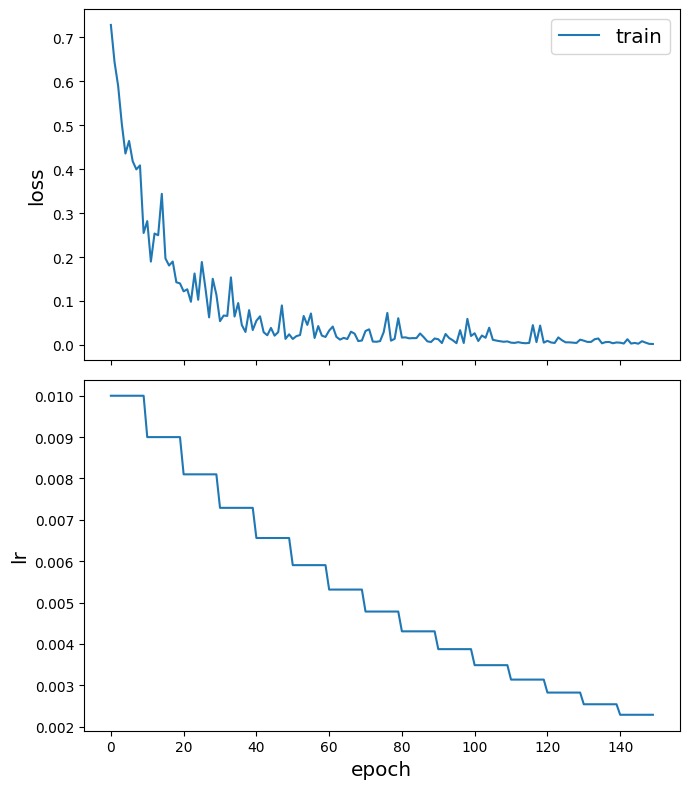

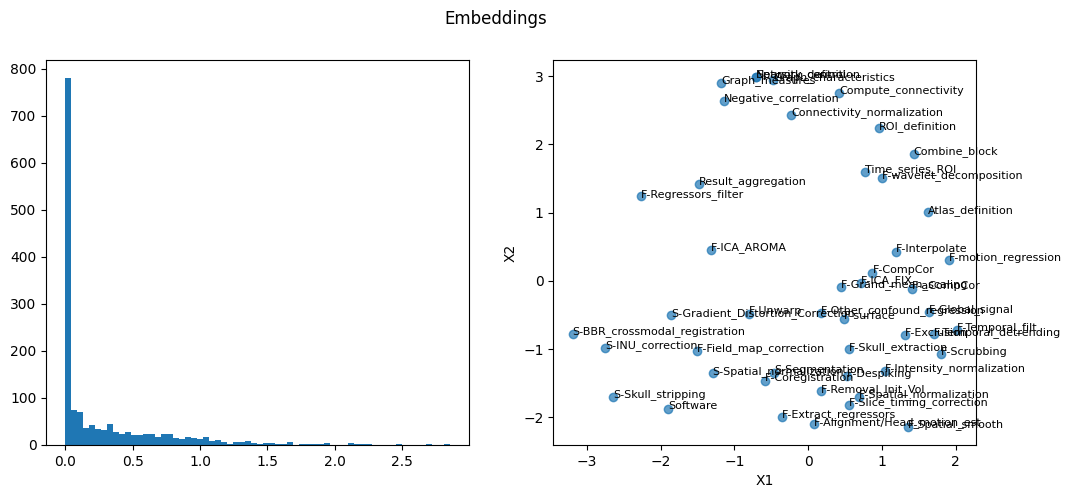

In [12]:
features = ["frequency", "indegree", "outdegree", "id_onehot", "groups_onehot"] # "betweenness" (betweenness is currently not used due to concerns with validity)
G, G_nx, nodes, node_features = create_graph(directed=True, features=features)
embeddings = run_deep_graph_infomax(G, layer_sizes=[32], activations=["relu"], epochs=150, learning_rate=1e-2, pat=80, history_plot=True)

print("Embeddings have shape:", embeddings.shape)
plot_embeddings(G, embeddings, type="MDS") # MDS or TSNE

# Save embeddings ans graph for evaluation in multiverse analysis
data_to_save = {
    "G": G,
    "G_nx": G_nx,
    "nodes": nodes,
    "node_features": node_features,
    "embeddings": embeddings,
}
with open(f"{wd}/multiverse/data/graph_and_embeddings.pkl", 'wb') as file:
    pickle.dump(data_to_save, file)